In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from keras.models import load_model

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [5]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


In [0]:
data.drop(columns = ['subtask_b' , 'subtask_c'] , inplace = True)

# Splitting Data: Train and Test


In [7]:
data['subtask_a'].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [8]:
Y = data['subtask_a']
X = data.drop(['subtask_a','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (13240, 8)
Shape of Y:  (13240,)


#### Observation: 
We see that the dataset is clearly imbalanced with NOT OFFENSIVE tweets being the majority class.


In [9]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y,random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (9268, 8)
Shape of Y_train:  (9268,)
Shape of X_test:  (3972, 8)
Shape of Y_test:  (3972,)


In [10]:
X_train['new_tweet'].head()

8902     1965 immigration act work exactly liberals hop...
10197                     interest you your state illinois
6956     people tire virtue signal wealthy liberals nev...
9853     i think you say write intelligent commentary h...
11952           she biggest thing she fail everywhere else
Name: new_tweet, dtype: object

#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(OFF=1, NOT=0))
Y_test = Y_test.map(dict(OFF=1, NOT=0))

In [0]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(X_train.isnull())
#  X_train[X_train.isna().any(axis=1)]

In [0]:
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal
from keras.engine import Layer, InputSpec
from keras import backend as K

def recall_m(y_true, y_pred):  
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f_m(y_true, y_pred):
    tmp = precision_recall_fscore_support(y_true , y_pred)
    return tmp[2][1]

## creating model

In [0]:
def create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output):
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # Define what the input shape looks like
    inputs = Input(shape=(maxlen,), dtype='int64')
    print('inputs shape: ',inputs.shape)
    a_func = 'relu'
    import tensorflow as tf

    def one_hot(x):
        return tf.one_hot(x, vocab_size, on_value=1.0, off_value=0.0, axis=-1, dtype=tf.float32)

    def one_hot_outshape(in_shape):
        return in_shape[0], in_shape[1], vocab_size

    embedded = Lambda(one_hot, output_shape=one_hot_outshape)(inputs)

    # All the convolutional layers...
    conv = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[0], kernel_initializer=initializer, 
                         padding='valid', activation = a_func,
                         input_shape=(maxlen, vocab_size), name='Conv1')(embedded)
    print('conv shape: ',conv.shape)
    conv = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool1')(conv)
    print('conv max pool shape: ',conv.shape)

    conv1 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[1], kernel_initializer=initializer, 
                          padding='valid', activation=a_func, name='Conv2')(conv)
    print('conv1 shape: ',conv1.shape)

    # conv1 = MaxPooling1D(pool_size=2,  strides = 2, name='MaxPool2')(conv1)
    # print('conv1 m.p shape: ',conv1.shape)

    conv2 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[2], kernel_initializer=initializer, 
                          padding='valid', activation=a_func, name='Conv3')(conv1)
    print('conv2 shape: ',conv2.shape)
    # conv2 = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool3')(conv2)
    # print('conv2 m.p shape: ',conv2.shape)

    conv3 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[3], kernel_initializer=initializer, 
                          padding='valid', activation=a_func, name='Conv4')(conv2)
    print('conv3 shape: ',conv3.shape)
    # conv3 = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool4')(conv3)
    # print('conv3 m.p shape: ',conv3.shape)

    # conv4 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[4], kernel_initializer=initializer,
    #                       padding='valid', activation=a_func, name='Conv5')(conv3)
    # print('conv4 shape: ',conv4.shape)
    # conv4 = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool5')(conv4)
    # print('conv4 m.p shape: ',conv4.shape)

    conv5 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[5], kernel_initializer=initializer,
                          padding='valid', activation=a_func,  name='Conv6')(conv3)
    print('conv5 shape: ',conv5.shape)

    conv5 = MaxPooling1D(pool_size=2, strides = 2, name='MaxPool6')(conv5)
    print('conv5 m.p shape: ',conv5.shape)

    # k = 40
    # # K-max pooling
    # def kmax_outshape(in_shape):
    #     return (in_shape[0], in_shape[2]*k)
    # def KMaxPooling(inputs):        
    #     # swap last two dimensions since top_k will be applied along the last dimension
    #     shifted_input = tf.transpose(inputs, [0, 2, 1])
    #     # extract top_k, returns two tensors [values, indices]
    #     top_k = tf.nn.top_k(shifted_input, k=k, sorted=True, name='TopK')[0]
    #     return top_k

    # conv5 = Lambda(KMaxPooling, output_shape=kmax_outshape)(conv5)
    conv5 = Flatten()(conv5)
    print('conv5 flatten shape: ',conv5.shape)

    # Two dense layers with dropout of .5
    z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(conv5))
    z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(z))

    # Output dense layer with softmax activation
    pred = Dense(cat_output, activation='softmax', name='output')(z)

    model = Model(inputs=inputs, outputs=pred)
    print(model.summary())
    sgd = SGD(lr=0.01, momentum=0.9)
    adam = Adam(lr=0.001)  # Feel free to use SGD above. I found Adam with lr=0.001 is faster than SGD with lr=0.01
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1_m ,precision_m, recall_m])
    # model.compile(loss= [focal_loss] ,optimizer=adam, metrics=['accuracy',  f1_m ,precision_m, recall_m])
    # model.compile(loss=focal_loss(alpha=1),optimizer='nadam',metrics=['accuracy'])

    return model

## Making Data Model Ready: Encoding Tweets

### Quantization  

In [0]:
def encode_data(x, maxlen, vocab):
    # Iterate over the loaded data and create a matrix of size (len(x), maxlen)
    # Each character is encoded into a one-hot array later at the lambda layer.
    # Chars not in the vocab are encoded as -1, into an all zero vector.
    
    input_data = np.zeros((len(x), maxlen), dtype=np.int)
    for dix, sent in enumerate(x):
        counter = 0
        for c in sent:
            if counter >= maxlen:
                pass
            else:
                ix = vocab.get(c, -1)  # get index from vocab dictionary, if not in vocab, return -1
                input_data[dix, counter] = ix
                counter += 1
    return input_data


def create_vocab_set():
    # This alphabet is 69 chars vs. 70 reported in the paper since they include two
    # '-' characters. See https://github.com/zhangxiangxiao/Crepe#issues.

    alphabet = set(list(string.ascii_lowercase) + list(string.digits) +
                   list(string.punctuation) + ['\n'])
    vocab_size = len(alphabet)
    vocab = {}
    reverse_vocab = {}
    for ix, t in enumerate(alphabet):
        vocab[t] = ix
        reverse_vocab[ix] = t

    return vocab, reverse_vocab, vocab_size, alphabet



In [0]:
vocab, reverse_vocab, vocab_size, alphabet = create_vocab_set()

# Maximum encoding length. Longer gets chopped. Shorter gets padded.
max_encode_len = 1500

## feature sets

In [17]:
f1 = encode_data(X_train['new_tweet'], max_encode_len, vocab)
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
f6 = X_train['new_tweet_length'].values.reshape(-1,1)
f7 = X_train['original_tweet_length'].values.reshape(-1,1)

# X_train_bow = np.concatenate((f1 , f2 , f3 , f4 , f5 , f6 , f7 ) , axis = 1)
X_train_bow = np.concatenate((f1 , f2 , f3 , f4 ,  f7 ) , axis = 1)

print(X_train_bow.shape)


(9268, 1504)


In [18]:
f1 = encode_data(X_test['new_tweet'], max_encode_len, vocab)
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
f6 = X_test['new_tweet_length'].values.reshape(-1,1)
f7 = X_test['original_tweet_length'].values.reshape(-1,1)


# X_test_bow = np.concatenate((f1 , f2 , f3 , f4 , f5 , f6 , f7 ) , axis = 1)
X_test_bow = np.concatenate((f1 , f2 , f3 , f4 ,  f7 ) , axis = 1)

print(X_test_bow.shape)


(3972, 1504)


In [19]:
Y_train_cat  = to_categorical(Y_train) 
Y_test_cat = to_categorical(Y_test)

class_weight = {1:  1 - Y_train.sum()/Y_train.shape[0] , 0 : Y_train.sum()/Y_train.shape[0] }
print("Class_weights : " ,  class_weight)

print(X_train_bow.shape , Y_train.shape , Y_train_cat.shape)
print(X_test_bow.shape , Y_test.shape ,  Y_test_cat.shape)

Class_weights :  {1: 0.6676737160120846, 0: 0.3323262839879154}
(9268, 1504) (9268,) (9268, 2)
(3972, 1504) (3972,) (3972, 2)


## Using k-fold

In [0]:
np.random.seed(123)  # for reproducibility
save = False
model_name_path = root_path + 'CNN/A_params/crepe_model.json'
model_weights_path = root_path + 'CNN/A_params/crepe_model_weights.h5'

# Model params
# Maximum encoding length. Longer gets chopped. Shorter gets padded.
maxlen = X_train_bow.shape[1]
# Filters for conv layers
nb_filter = 512
# Number of units in the dense layer
dense_outputs = 1024
# Conv layer kernel size
filter_kernels = [7,5,3,2,2,1]
# Number of units in the final output layer. Number of classes.
cat_output = 2

# Compile/fit params
batch_size = 80
nb_epoch = 20

alphabet = set(list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ['\n'])
vocab_size =  len(alphabet)

In [0]:


seed = 10
fold = 1

kfold = StratifiedKFold(n_splits=3)

# kfold.get_n_splits(X_train_bow)
cvscores = []
testscores = []
test_predictions = []

for train, val in kfold.split(X_train_bow  , Y_train):
    print("------------------------------------------------------------------------------")
    print("FOLD ", fold)

    model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output)

    model.fit( X_train_bow[train] , Y_train_cat[train] ,class_weight = class_weight , batch_size=batch_size, epochs=nb_epoch, validation_split=0.0)
    
    val_score = model.evaluate( X_train_bow[val], Y_train_cat[val] , verbose=0)
    test_score = model.evaluate( X_test_bow , Y_test_cat , verbose=0 )
    temp_pred = model.predict(X_test_bow)
    test_predictions.append(temp_pred.argmax(axis = 1))
    
    print("\n =====   Fold ==== " ,  fold , " : " , val_score[1])
    
    cvscores.append(val_score[1]*100)
    testscores.append(test_score[1]*100)

    fold += 1

print("------------------------------------------------------------------------------")
print("Validation Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Test Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(testscores), np.std(testscores)))


------------------------------------------------------------------------------
FOLD  1


inputs shape:  (?, 1504)

conv shape:  (?, 1498, 512)

conv max pool shape:  (?, 749, 512)
conv1 shape:  (?, 745, 512)
conv2 shape:  (?, 743, 512)
conv3 shape:  (?, 742, 512)
conv5 shape:  (?, 742, 512)
conv5 m.p shape:  (?, 371, 512)
conv5 flatten shape:  (?, ?)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1504)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1504, 69)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1498, 512)         247808    
___________________________________________________

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      2652
           1       0.43      0.30      0.35      1320

    accuracy                           0.63      3972
   macro avg       0.56      0.55      0.55      3972
weighted avg       0.61      0.63      0.61      3972



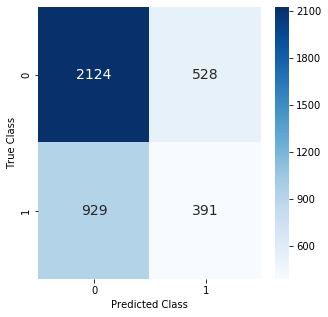

In [0]:
# if sum is (0 or 1) -> 0(predicted class )  else (2 , 3) -> 1
# final_prediction = np.sum(np.array(test_predictions).T , axis = 1)//2
from scipy import stats

final_prediction = stats.mode(np.array(test_predictions).T,axis=1)[0].flatten()
print(classification_report(Y_test.values , final_prediction))
results = confusion_matrix(Y_test.values , final_prediction)

%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
print("Y_test: ",Y_test.values)

Y_test:  [0 0 0 ... 1 0 0]


In [0]:
print("final_prediction: ",final_prediction)

final_prediction:  [0 0 0 ... 0 0 0]


In [0]:
f1_score(Y_test, final_prediction, average='weighted')  

0.6132258159775238

## Without k-fold

In [21]:
X_final_data = np.concatenate((X_train_bow, X_test_bow) , axis = 0)
Y_final_data = np.concatenate((Y_train , Y_test) ,axis = 0)
Y_final_data_cat = to_categorical(Y_final_data)
print(X_final_data.shape)
print(Y_final_data.shape)

(13240, 1504)
(13240,)


In [23]:
model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output)
model.fit( X_final_data , Y_final_data_cat , class_weight =  class_weight , batch_size=batch_size, epochs=nb_epoch, validation_split=0.0)

inputs shape:  (?, 1504)
conv shape:  (?, 1498, 512)
conv max pool shape:  (?, 749, 512)
conv1 shape:  (?, 745, 512)
conv2 shape:  (?, 743, 512)
conv3 shape:  (?, 742, 512)
conv5 shape:  (?, 742, 512)
conv5 m.p shape:  (?, 371, 512)
conv5 flatten shape:  (?, ?)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1504)              0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1504, 69)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1498, 512)         247808    
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 749, 512)          0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 745, 512)          131123

In [0]:
y_test_predict = model.predict(X_test_bow)
y_test_predict_cat = y_test_predict.argmax(axis = 1)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2652
           1       0.99      0.97      0.98      1320

    accuracy                           0.99      3972
   macro avg       0.99      0.98      0.98      3972
weighted avg       0.99      0.99      0.99      3972



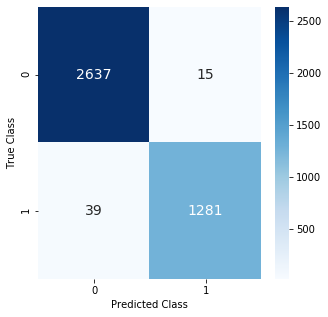

In [25]:
print(classification_report(Y_test.values , y_test_predict_cat))
results = confusion_matrix(Y_test.values , y_test_predict_cat)

%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [26]:
f1_score(Y_test, y_test_predict_cat , average='weighted')  

0.9863730904329313

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict_cat)

In [28]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

54 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [30]:
#OFF=1, NOT=0)
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict_cat[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER I was think she jisoo but I’m Focused I found she is taeyoun
 @USER Fool
 @USER @USER WHAT A DOG..SHE IS...
 @USER Clown
 @USER I blame @USER for inciting violence and she should be held accountable! She is a despicable disgrace.
 @USER @USER Popular side doesn’t equal winning side. Facts are that private schools do a much better job educating students than public schools. Public school teachers get unfair perks that they don’t deserve. It’s unfair to private school teachers.
 @USER Then I see like this and lust over the girl with the long blond hair and the bare midriff and micro-mini and realize she is now 48 years older and could be a great grandmother today! 😱 People wonder why I love legs until I show them what I grew up with. URL
 @USER Looks Like The Jokes On Liberals Again.  #FortTrump #Poland #BoomingEconomy URL
 @USER And I will never watch your movies again because you are a maniac!
 @USER @USER @USER I have been thinking about it and it's not inconceivable that someo

In [31]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open(root_path + "/CNN/model_A.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(root_path + "/CNN/model_A.h5")
print("Saved model to disk")
 

Saved model to disk
